In [15]:
#Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import glm
import statsmodels.api as sm
from pygam import PoissonGAM, s

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 100})

#LOADING AND CLEANING THE DATA

In [2]:
df = pd.read_csv("dataset/PHILIPPINES_DATA_19.csv")
df = df.replace([" ", "NA", "NaN", "nan"], np.nan).dropna()
df['CR7'] = pd.to_numeric(df['CR7'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6614 entries, 2 to 10600
Data columns (total 70 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FinalWgt  6614 non-null   float64
 1   CR1       6614 non-null   float64
 2   CR2       6614 non-null   float64
 3   PHR3      6614 non-null   float64
 4   PHR4      6614 non-null   float64
 5   PHR5      6614 non-null   float64
 6   CR5       6614 non-null   float64
 7   CR6       6614 non-null   float64
 8   CR7       6614 non-null   float64
 9   CR8       6614 non-null   float64
 10  PHR10     6614 non-null   float64
 11  SR1       6614 non-null   float64
 12  CR9       6614 non-null   float64
 13  CR10      6614 non-null   float64
 14  OR9       6614 non-null   float64
 15  CR11      6614 non-null   float64
 16  CR12      6614 non-null   float64
 17  CR13      6614 non-null   float64
 18  CR14      6614 non-null   float64
 19  ELR1      6614 non-null   float64
 20  PHR20     6614 non-null   float64


In [3]:
# Create smoker status: 1 = smoker (CR7 > 1), 0 = non-smoker
df['smoker_status'] = np.where(df['CR7'] > 1, 1, 0)
df['smoker_status'].head()

2    0
3    0
4    0
5    0
6    0
Name: smoker_status, dtype: int64

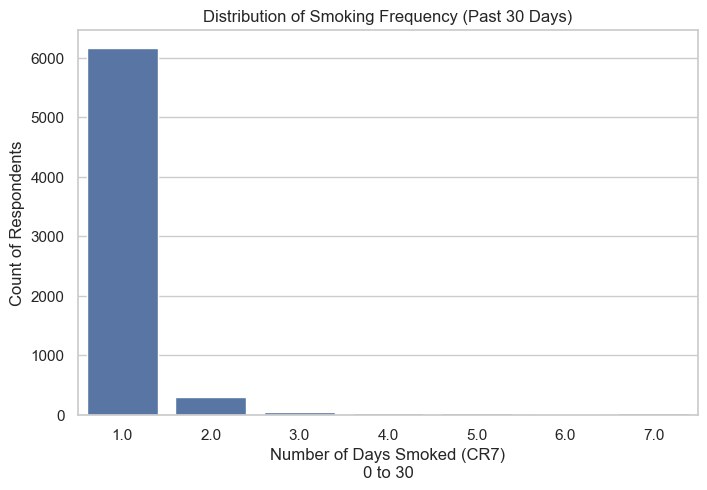

In [4]:
plt.figure(figsize=(8,5))
sns.countplot(x='CR7', data=df)
plt.title('Distribution of Smoking Frequency (Past 30 Days)')
plt.xlabel('Number of Days Smoked (CR7)\n0 to 30')
plt.ylabel('Count of Respondents')
plt.show()

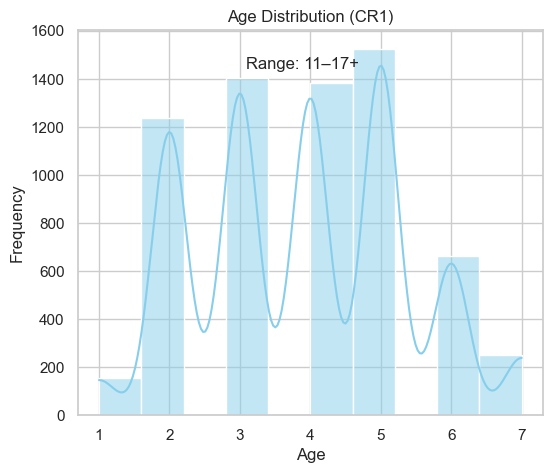

In [5]:
plt.figure(figsize=(6,5))
sns.histplot(df['CR1'], bins=10, kde=True, color='skyblue')
plt.title('Age Distribution (CR1)')
plt.xlabel('Age')
plt.xticks(ticks=range(int(df['CR1'].min()), int(df['CR1'].max()) + 1))
plt.ylabel('Frequency')
plt.text(df['CR1'].mean(), plt.ylim()[1]*0.9, 'Range: 11–17+', ha='center')
plt.show()

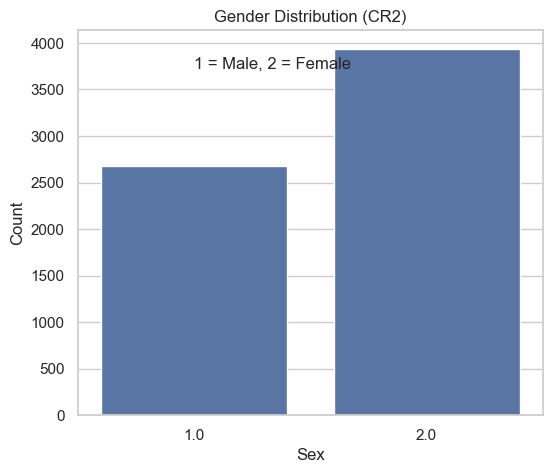

In [6]:
plt.figure(figsize=(6,5))
sns.countplot(x='CR2', data=df)
plt.title('Gender Distribution (CR2)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.text(0, plt.ylim()[1]*0.9, '1 = Male, 2 = Female', ha='left')
plt.show()

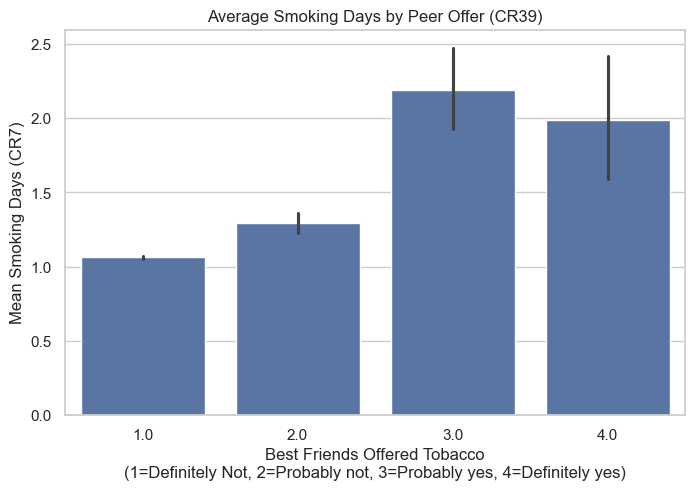

In [7]:
plt.figure(figsize=(8,5))
sns.barplot(x='CR39', y='CR7', data=df, estimator=np.mean)
plt.title('Average Smoking Days by Peer Offer (CR39)')
plt.xlabel('Best Friends Offered Tobacco\n(1=Definitely Not, 2=Probably not, 3=Probably yes, 4=Definitely yes)')
plt.ylabel('Mean Smoking Days (CR7)')
plt.show()

## GLM MODEL

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CR7   No. Observations:                 6614
Model:                            GLM   Df Residuals:                     6603
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7165.2
Date:                Tue, 28 Oct 2025   Deviance:                       711.46
Time:                        09:44:56   Pearson chi2:                     886.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08219
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1612      0.136      8.513      0.0

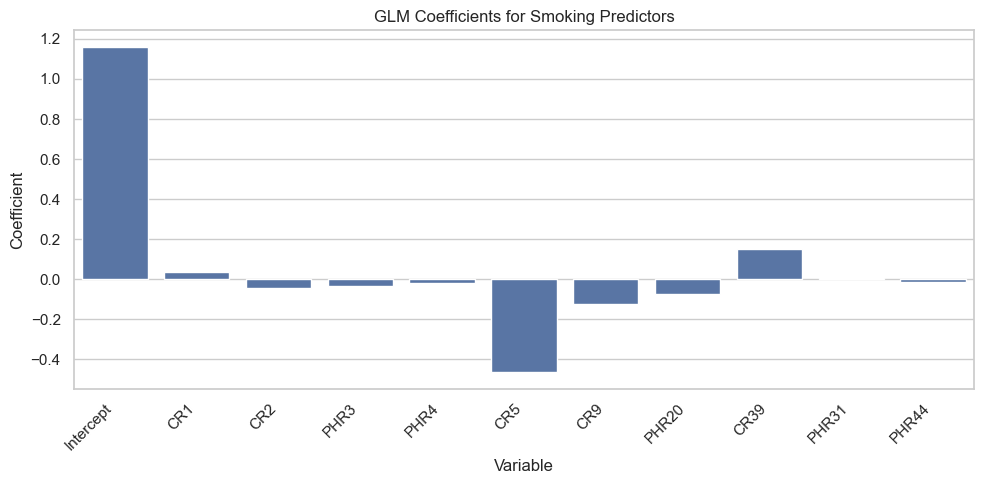

In [8]:
# GLM Poisson model 
formula = 'CR7 ~ CR1 + CR2 + PHR3 + PHR4 + CR5 + CR9 + PHR20 + CR39 + PHR31 + PHR44'
glm_model = glm(formula=formula, data=df, family=sm.families.Poisson()).fit()
print(glm_model.summary())

# Coefficient bar chart
coef_df = glm_model.params.reset_index()
coef_df.columns = ['Variable', 'Coefficient']
plt.figure(figsize=(10,5))
sns.barplot(data=coef_df, x='Variable', y='Coefficient')
plt.xticks(rotation=45, ha='right')
plt.title('GLM Coefficients for Smoking Predictors')
plt.tight_layout()
plt.show()

## GAM MODEL

c:\Users\John Paul\Desktop\termpaper\.venv\lib\site-packages\pygam\pygam.py:2858: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()


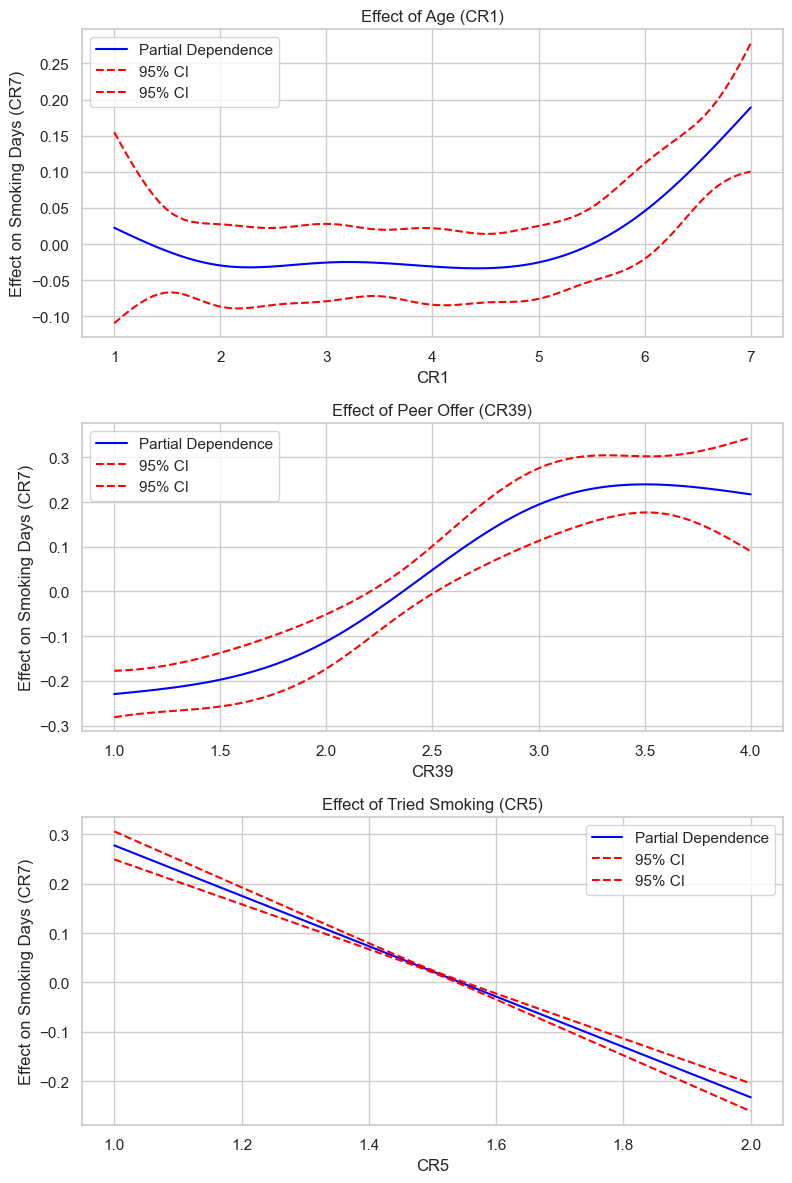

In [9]:
# Poisson GAM on selected predictors 
X = df[['CR1', 'CR39', 'CR5']].apply(pd.to_numeric, errors='coerce')
y = df['CR7']
gam = PoissonGAM(s(0) + s(1) + s(2)).fit(X, y)

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
titles = ['Effect of Age (CR1)', 'Effect of Peer Offer (CR39)', 'Effect of Tried Smoking (CR5)']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color='blue', label='Partial Dependence')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], color='red', linestyle='--', label='95% CI')
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel(X.columns[i])
    ax.set_ylabel('Effect on Smoking Days (CR7)')
    ax.legend()
plt.tight_layout()
plt.show()

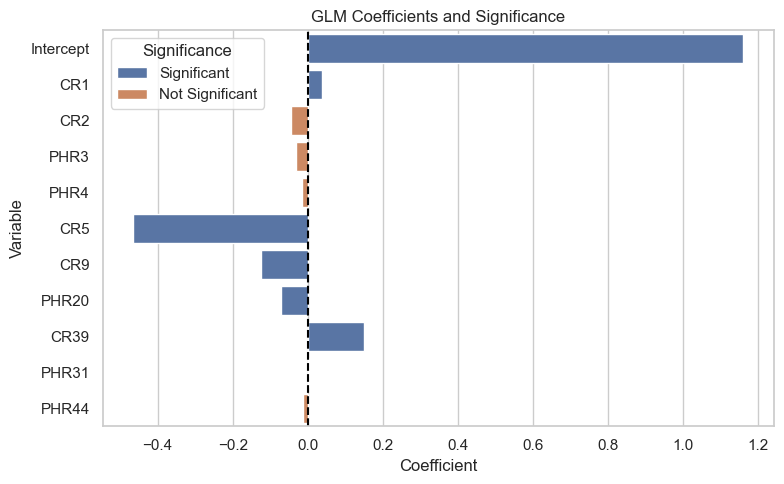

In [11]:
# Coefficient/significance, predicted vs actual, residuals
coef_df = pd.DataFrame({
    'Variable': glm_model.params.index,
    'Coefficient': glm_model.params.values,
    'P>|z|': glm_model.pvalues
})
coef_df['Significance'] = coef_df['P>|z|'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')
plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Variable', data=coef_df, hue='Significance', dodge=False)
plt.title('GLM Coefficients and Significance')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


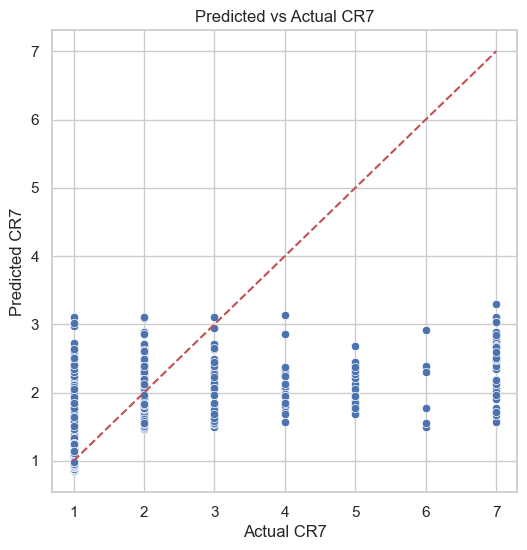

In [12]:
df['Predicted_CR7'] = glm_model.predict(df)
plt.figure(figsize=(6,6))
sns.scatterplot(x=df['CR7'], y=df['Predicted_CR7'])
plt.plot([df['CR7'].min(), df['CR7'].max()], [df['CR7'].min(), df['CR7'].max()], 'r--')
plt.title('Predicted vs Actual CR7')
plt.xlabel('Actual CR7')
plt.ylabel('Predicted CR7')
plt.show()


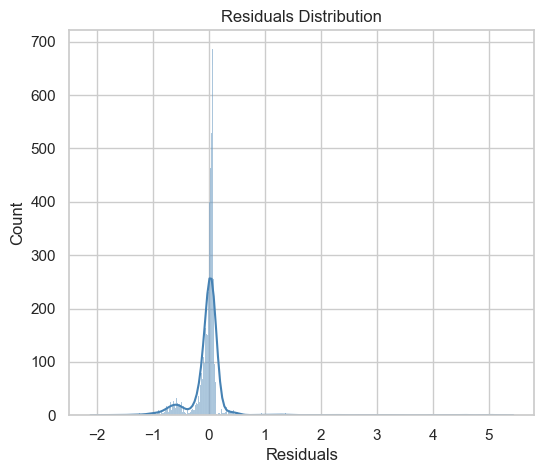

In [13]:
residuals = df['CR7'] - df['Predicted_CR7']
plt.figure(figsize=(6,5))
sns.histplot(residuals, kde=True, color='steelblue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()